In [1]:
!pip install -U langchain_community tiktoken langchain-groq langchainhub chromadb langchain langgraph langchain_huggingface
!pip install InstructorEmbedding faiss-cpu PyPDF2 sentence-transformers==2.2.2

  Using cached sentence_transformers-3.0.1-py3-none-any.whl.metadata (10 kB)
Using cached sentence_transformers-3.0.1-py3-none-any.whl (227 kB)
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 2.2.2
    Uninstalling sentence-transformers-2.2.2:
      Successfully uninstalled sentence-transformers-2.2.2
  Using cached sentence_transformers-2.2.2-py3-none-any.whl
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 3.0.1
    Uninstalling sentence-transformers-3.0.1:
      Successfully uninstalled sentence-transformers-3.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-huggingface 0.0.3 requires sentence-transformers>=2.6.0, but you have sentence-transformers 2.2.2 which is incompatible.


In [2]:
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.vectorstores import FAISS
from PyPDF2 import PdfReader
from langchain.schema import Document


def pdf_handler_with_store(file_path):

  text = ''
  pdf_reader = PdfReader(file_path)
  for page in pdf_reader.pages:
    text += page.extract_text()
  final_text = Document(page_content = text)
  return final_text


In [3]:
#Router
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

#data model
class RouteQuery(BaseModel):
  """Route a user query to the most relevant datasource."""
  datasource: Literal["vectorstore", "wiki_search"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore or research.",
    )

from google.colab import userdata
# LLM with function call
from langchain_groq import ChatGroq
import os
groq_api_key=userdata.get('GROQ_API_KEY')
os.environ["GROQ_API_KEY"]=groq_api_key
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia or research.
go to the vectorstore in case the user prompt mentions like from the pdf, pdf provide , based on context. In case user question mention like write sop, abstract, or any thing related to a paper go to research. Otherwise, use wiki-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)
question_router = route_prompt | structured_llm_router
'''
print(
    question_router.invoke(
        {"question": "who is Sharukh Khan?"}
    )
)
print(question_router.invoke({"question": "What are the types of agent memory?"}))
'''

'\nprint(\n    question_router.invoke(\n        {"question": "who is Sharukh Khan?"}\n    )\n)\nprint(question_router.invoke({"question": "What are the types of agent memory?"}))\n'

In [4]:
!pip install wikipedia arxiv

In [5]:
### Working With Tools
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv and wikipedia Tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [6]:
## Graph

from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [7]:
from langchain.schema import Document
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.vectorstores import FAISS
from PyPDF2 import PdfReader
from langchain.schema import Document


def pdf_handler_with_store(file_path):

  text = ''
  pdf_reader = PdfReader(file_path)
  for page in pdf_reader.pages:
    text += page.extract_text()


  text_splitter = CharacterTextSplitter(
        separator= "\n" ,
        chunk_size=1000,
        chunk_overlap=200,
        length_function= len
        )
  chunks = text_splitter.split_text(text)
  embeddings = HuggingFaceInstructEmbeddings(model_name="hkunlp/instructor-xl")
  vectorstore = FAISS.from_texts(texts=chunks, embedding=embeddings)
  return vectorstore

path = '/content/sodapdf-converted.pdf'

vectorstore = pdf_handler_with_store(path)

retriever = vectorstore.as_retriever()




/usr/local/lib/python3.10/dist-packages/InstructorEmbedding/instructor.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


load INSTRUCTOR_Transformer
max_seq_length  512


/usr/local/lib/python3.10/dist-packages/sentence_transformers/models/Dense.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join

In [20]:

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]
    def list_to_document(content_list):
        text = ''
        for element in content_list:
          text += str(element) + ' '  # Add space as separator
        return Document(page_content=text)

    # Retrieval
    take  = retriever.invoke(question)
    documents = list_to_document(take)
    return {"documents": documents, "question": question}

def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---wikipedia---")
    print("---HELLO--")
    question = state["question"]
    print(question)

    # Wiki search
    docs = wiki.invoke({"query": question})
    #print(docs["summary"])
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}

def research(state):
# LLM with function call
  from langchain_groq import ChatGroq
  groq_api_key='your key'
  llm=ChatGroq(groq_api_key=groq_api_key,model_name="llama3-8b-8192")
  question = state["question"]
  result = llm.invoke(state['question'])
  output = Document(page_content=result.content)
  return {"documents": output, "question": question}


In [21]:
### Edges ###


'''def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "research":
        print("---ROUTE QUESTION TO research-llm---")
        return "research"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"'''
### Edges ###

def route_question(state):
    """
    Route question to wiki search, RAG, or research-llm.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]

    if "research" in question.lower():
        print("---ROUTE QUESTION TO research-llm---")
        return "research"
    elif "pdf" in question.lower() or "context" in question.lower():  # Example condition for vectorstore - adjust as needed
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"
    else:
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"

In [22]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)
# Define the nodes
workflow.add_node("wiki_search", wiki_search)  # web search
workflow.add_node("research", research)
workflow.add_node("retrieve", retrieve) # retrieve

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "research": "research",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge( "retrieve", END)
workflow.add_edge( "research", END)
workflow.add_edge( "wiki_search", END)
# Compile
app = workflow.compile()

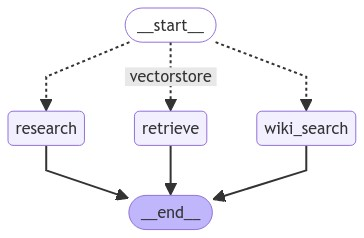

In [11]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
from pprint import pprint

# Run
inputs = {
    "question": "What is agent?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'].page_content)


---ROUTE QUESTION---
---ROUTE QUESTION TO Wiki SEARCH---
---wikipedia---
---HELLO--
What is agent?
"Node 'wiki_search':"
'\n---\n'
('Page: Agent Orange\n'
 'Summary: Agent Orange is a chemical herbicide and defoliant, one of the '
 'tactical use Rainbow Herbicides. It was used by the U.S. military as part of '
 'its herbicidal warfare program, Operation Ranch Hand, during the Vietnam War '
 'from 1961 to 1971. It is a mixture of equal parts of two herbicides, 2,4,5-T '
 'and 2,4-D. In addition to its damaging environmental effects, traces of '
 'dioxin (mainly TCDD, the most toxic of its type) found in the mixture have '
 'caused major health problems and deformities for many individuals who were '
 'exposed, and their children.\n'
 'Agent Orange was produced in the United States from the late 1940s and was '
 'used in industrial agriculture, and was also sprayed along railroads and '
 'power lines to control undergrowth in forests. During the Vietnam War, the '
 'U.S. military procure

In [24]:
from pprint import pprint

# Run
inputs = {
    "question": "write a sop for the research on fine tuning llm for medical use cases"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'].page_content)


---ROUTE QUESTION---
---ROUTE QUESTION TO research-llm---
"Node 'research':"
'\n---\n'
('Here is a draft Standard Operating Procedure (SOP) for fine-tuning Large '
 'Language Models (LLMs) for medical use cases:\n'
 '\n'
 '**Title:** Fine-Tuning Large Language Models for Medical Use Cases SOP\n'
 '\n'
 '**Purpose:** To outline the steps for fine-tuning Large Language Models '
 '(LLMs) for medical use cases, ensuring consistency, quality, and '
 'reproducibility in the research process.\n'
 '\n'
 '**Scope:** This SOP applies to all researchers, students, and staff involved '
 'in fine-tuning LLMs for medical use cases at [Institution Name].\n'
 '\n'
 '**Responsibilities:**\n'
 '\n'
 '* Principal Investigator (PI): Responsible for overall project direction, '
 'ensuring compliance with this SOP, and approving all research outputs.\n'
 '* Researchers: Responsible for conducting fine-tuning experiments, '
 'collecting and processing data, and reporting results.\n'
 '* Research Assistants: 

In [23]:
from pprint import pprint

# Run
inputs = {
    "question": "provide the content from the pdf"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'].page_content)


---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
("page_content='Sure! Here's a brief conversation between two people:  \n"
 '  \n'
 '---  \n'
 '  \n'
 '**Alex:** Hey Taylor, how was your weekend?  \n'
 '  \n'
 '**Taylor:** Hi Alex! It was great, thanks for asking. I went hiking on '
 'Saturday and just relaxed at home on \n'
 'Sunday. How about you?  \n'
 '  \n'
 '**Alex:** That sounds awesome! I spent most of my weekend catching up on '
 'some work and watched a \n'
 'few movies.   \n'
 '  \n'
 '**Taylor:** Nice, any recommendations for the movies?  \n'
 '  \n'
 "**Alex:** Definitely! If you haven't seen *Inception*, it's a must-watch. "
 'And I really enjoyed *The Grand \n'
 'Budapest Hotel* too.  \n'
 '  \n'
 "**Taylor:** I'll check those out. Thanks for the suggestions!   \n"
 '  \n'
 "**Alex:** No problem. Let me know what you think once you've watched "
 'them!  \n'
 '  \n'
 '**Taylor:** Will do. See you around!  \n'
 '  \n'
 '**Alex:*